In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [2]:
def print_statistics(array, label=None):
    if label is not None:
        print(label)

    if array.ndim == 1:
        print(f"min  = {array.min():.4f}")
        print(f"max  = {array.max():.4f}")
        # print(f"sum = {array.sum():.4f}")
        print(f"mean = {array.mean():.4f}\n")

    elif array.ndim == 2:
        print(f"min  = {array.min(axis=0)}")
        print(f"max  = {array.max(axis=0)}")
        # print(f"sum = {array.sum(axis=0)}")
        print(f"mean = {array.mean(axis=0)}\n")

### galaxy density contrast $\delta_g$

In [3]:
with h5py.File("/Users/arne/data/CosmoGrid_example/DES/projected_probes_maps_nobaryons512.h5", "r") as f:
    # print(f["dg"].keys())
    # dg = f["dg/desy3maglim1"][:]
    dg = np.stack([f["dg/desy3maglim1"][:], f["dg/desy3maglim2"][:], f["dg/desy3maglim3"][:], f["dg/desy3maglim4"][:]], axis=-1)

# raw
print_statistics(dg, "raw")

# mean zero and normalized (like eq. 7 in DeepLSS)
dg = (dg - np.mean(dg, axis=0, keepdims=True))/np.mean(dg, axis=0, keepdims=True)
print_statistics(dg, "mean zero and normalized")

raw
min  = [0.41140702 0.43473336 0.46160516 0.4837826 ]
max  = [14.0855875 12.37435    6.422544   5.4486103]
mean = [0.9988925  1.0004025  0.99897695 0.99925107]

mean zero and normalized
min  = [-0.5881368  -0.5654415  -0.5379221  -0.51585484]
max  = [13.101205  11.369371   5.429121   4.4526944]
mean = [-1.4839058e-04  6.7413501e-05  1.6749429e-04  2.7678660e-04]



### galaxy number $n_g$

In [4]:
# number of galaxies per pixel
n_gal = 10
bg = 3.0

# raw galaxy count, might contain pixel values that are below zero
ng = n_gal * (1 + bg * dg)
print_statistics(ng, "raw galaxy count")

# DeepLSS like rescaling (see Appendix E)
ng_clip = np.clip(ng, a_min=0, a_max=None)
ng_deeplss = ng_clip * np.sum(ng)/np.sum(ng_clip)
# ng_deeplss = ng_clip * np.sum(ng_clip)/np.sum(ng)
print_statistics(ng_deeplss, "DeepLSS transform")

# naive clipping
ng_naive = np.clip(ng, a_min=0, a_max=None)
print_statistics(ng_naive, "naive clipping")

raw galaxy count
min  = [-7.644104  -6.9632444 -6.137662  -5.475645 ]
max  = [403.03616 351.08118 172.87363 143.58084]
mean = [ 9.995507 10.002016 10.005134 10.008398]

DeepLSS transform
min  = [0. 0. 0. 0.]
max  = [401.55933 349.7947  172.24017 143.05472]
mean = [10.037737  9.999565  9.986968  9.979518]

naive clipping
min  = [0. 0. 0. 0.]
max  = [403.03616 351.08118 172.87363 143.58084]
mean = [10.0747   10.036241 10.023636 10.016271]



# smoothing

In [5]:
from msfm.utils import redshift, clustering, scales, files
import healpy as hp

23-08-29 14:35:23    scales.py INF   Setting up healpy to run on 10 CPUs 


In [6]:
# constants
conf = files.load_config()
data_vec_pix, _, _, _ = files.load_pixel_file()
n_side = 512
n_pix = hp.nside2npix(n_side)

# bias and redshift evolution
tomo_z_maglim, tomo_nz_maglim = files.load_redshift_distributions("maglim", conf)
tomo_n_gal_maglim = np.array(conf["survey"]["maglim"]["n_gal"]) * hp.nside2pixarea(n_side, degrees=True)

z0 = 0.62
n_bg = 3.0

for bg in [0.5, 1.5, 2.5]:
    # tomo_bg = redshift.get_tomo_amplitudes(bg, n_bg, tomo_z_maglim, tomo_nz_maglim, z0)
    tomo_bg = [bg, bg, bg, bg]
    print(f"bg = {bg}, tomo_bg = {tomo_bg}")

    # non-scaled galaxy number per pixel
    ng = n_gal * (1 + tomo_bg * dg)

    # DeepLSS transform
    ng_clip = np.clip(ng, a_min=0, a_max=None)
    ng_deeplss = ng_clip * np.sum(ng)/np.sum(ng_clip)

    # naive transform
    ng_naive = np.clip(ng, a_min=0, a_max=None)

    def smoothing(ng_full):
        # nested ordering
        for i in range(ng_full.shape[-1]):
            ng_full[:,i] = hp.reorder(ng_full[:,i], r2n=True)
            
        # data vector instead of full map
        ng_dv = ng_full[data_vec_pix]

        ng_dv = scales.data_vector_to_smoothed_data_vector(
            ng_dv,
            l_min=[30, 30, 30, 30],
            # l_min=[0, 0, 0, 0],
            # l_min=[1, 1, 1, 1],
            l_max=[328, 478, 621, 739],
            n_side=n_side,
            data_vec_pix=data_vec_pix,
        )

        return ng_dv

    smooth_ng_deeplss = smoothing(ng_deeplss)
    smooth_ng_naive = smoothing(ng_naive)

    # print("before smoothing \n")
    # print_statistics(ng_deeplss, "DeepLSS")
    # print_statistics(ng_naive, "naive")
    # print(f"difference in total galaxy number = {np.sum(ng_deeplss) - np.sum(ng_naive)}")

    # print("after smoothing \n")
    # print_statistics(smooth_ng_deeplss, "DeepLSS")
    print_statistics(smooth_ng_naive, "naive")
    # print(f"difference in total galaxy number = {np.sum(smooth_ng_deeplss) - np.sum(smooth_ng_naive)}")

23-08-29 14:35:23     files.py INF   Loaded the pixel file /Users/arne/git/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5 
bg = 0.5, tomo_bg = [0.5, 0.5, 0.5, 0.5]
naive
min  = [-3.3840308 -3.078699  -3.302466  -3.427077 ]
max  = [ 8.446165  9.665419 10.807458 11.038347]
mean = [0.44960254 0.47788754 0.49306646 0.5002577 ]

bg = 1.5, tomo_bg = [1.5, 1.5, 1.5, 1.5]
naive
min  = [-7.245047  -6.783715  -7.1731277 -6.948365 ]
max  = [17.93786  20.49897  18.304527 21.525045]
mean = [0.4513266  0.48047718 0.49627614 0.5012867 ]

bg = 2.5, tomo_bg = [2.5, 2.5, 2.5, 2.5]
naive
min  = [-11.897764  -10.5967865 -10.679647  -10.641804 ]
max  = [30.024279 34.81049  29.37693  32.112816]
mean = [0.45343375 0.48320273 0.499564   0.50232375]



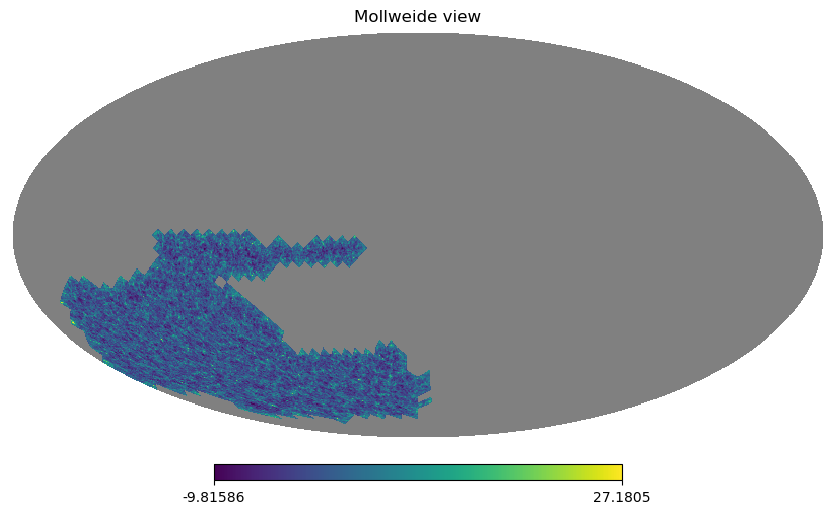

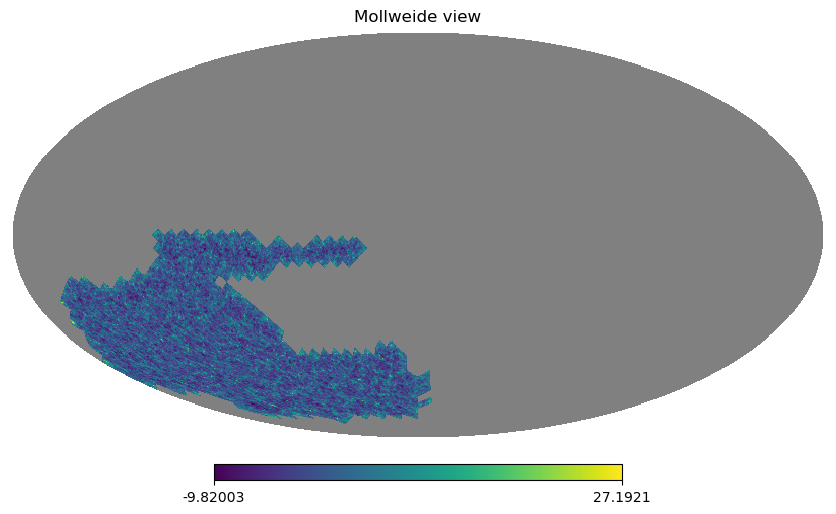

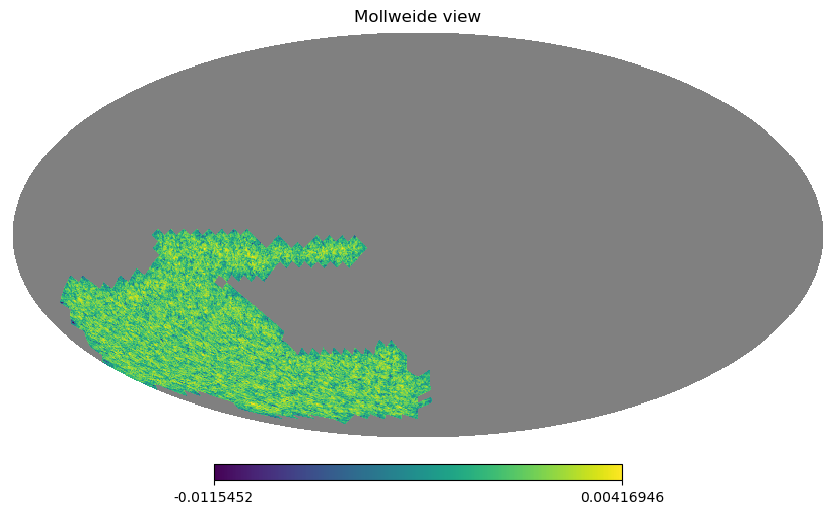

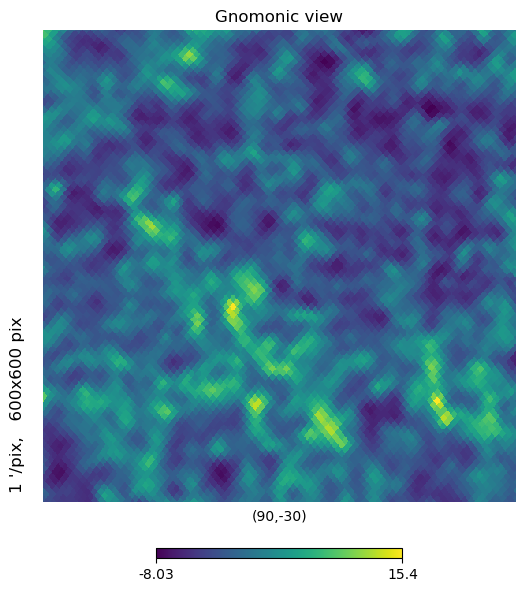

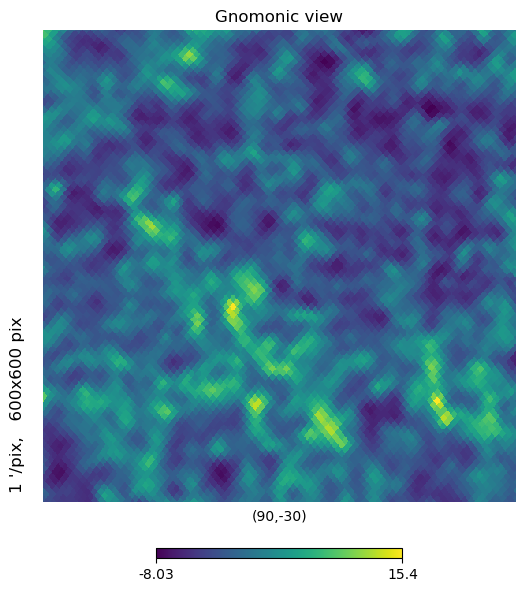

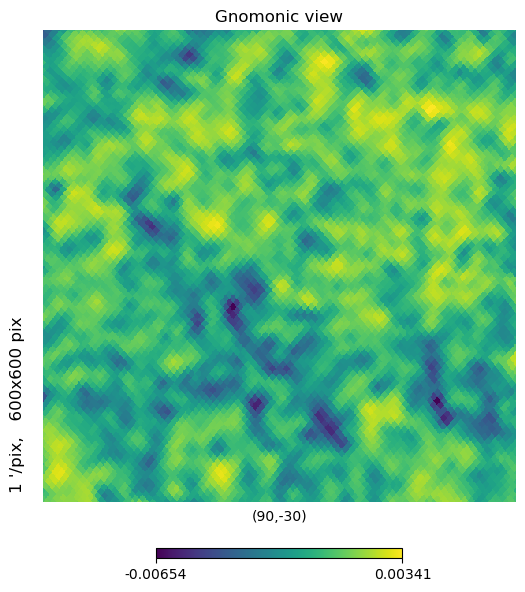

In [7]:
i_tomo = 3

# DeepLSS
hp_deeplss = np.full(n_pix, hp.UNSEEN)
hp_deeplss[data_vec_pix] = smooth_ng_deeplss[:,i_tomo]

# naive
hp_naive = np.full(n_pix, hp.UNSEEN)
hp_naive[data_vec_pix] = smooth_ng_naive[:,i_tomo]

# difference
hp_diff = np.full(n_pix, hp.UNSEEN)
hp_diff[data_vec_pix] = smooth_ng_deeplss[:,i_tomo] - smooth_ng_naive[:,i_tomo]

# mollview
hp.mollview(hp_deeplss, nest=True)
hp.mollview(hp_naive, nest=True)
hp.mollview(hp_diff, nest=True)

# gnomview
hp.gnomview(hp_deeplss, nest=True, rot=(90, -30, 0), reso=1, xsize=600, ysize=600)
hp.gnomview(hp_naive, nest=True, rot=(90, -30, 0), reso=1, xsize=600, ysize=600)
hp.gnomview(hp_diff, nest=True, rot=(90, -30, 0), reso=1, xsize=600, ysize=600)

# like in .tfrecord

In [8]:
from msfm.utils import maps

In [9]:
# constants
conf = files.load_config()
data_vec_pix, patches_pix_dict, corresponding_pix_dict, _ = files.load_pixel_file()
n_side = 512
n_pix = hp.nside2npix(n_side)

# bias and redshift evolution
tomo_z_maglim, tomo_nz_maglim = files.load_redshift_distributions("maglim", conf)
tomo_n_gal_maglim = np.array(conf["survey"]["maglim"]["n_gal"]) * hp.nside2pixarea(n_side, degrees=True)

z0 = 0.62
n_bg = 3.0

def clustering_transform(dg, bg, n_bg):
    # linear galaxy biasing
    tomo_bg = redshift.get_tomo_amplitudes(bg, n_bg, tomo_z_maglim, tomo_nz_maglim, z0)
    print(f"Per z bin bg = {tomo_bg}")

    galaxy_counts = clustering.galaxy_density_to_number(
        dg,
        tomo_n_gal_maglim,
        tomo_bg,
        conf=conf,
        include_systematics=conf["analysis"]["systematics"]["maglim_survey_systematics_map"],
    )

    galaxy_counts = clustering.galaxy_number_add_noise(galaxy_counts)

    galaxy_counts = scales.data_vector_to_smoothed_data_vector(
        galaxy_counts,
        l_min=conf["analysis"]["scale_cuts"]["clustering"]["l_min"],
        l_max=conf["analysis"]["scale_cuts"]["clustering"]["l_max"],
        n_side=conf["analysis"]["n_side"],
        data_vec_pix=data_vec_pix,
    )

    return galaxy_counts

23-08-29 14:35:30     files.py INF   Loaded the pixel file /Users/arne/git/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5 


In [10]:
patches_pix = patches_pix_dict["maglim"][0,:]
corresponding_pix = corresponding_pix_dict["maglim"]

dg_dv = np.stack([
    maps.map_to_data_vec(dg[:,0], len(data_vec_pix), corresponding_pix, patches_pix),
    maps.map_to_data_vec(dg[:,1], len(data_vec_pix), corresponding_pix, patches_pix),
    maps.map_to_data_vec(dg[:,2], len(data_vec_pix), corresponding_pix, patches_pix),
    maps.map_to_data_vec(dg[:,3], len(data_vec_pix), corresponding_pix, patches_pix),
], axis=-1)

for bg in [0.5, 1, 1.5, 2, 2.5]:
    smooth_ng = clustering_transform(dg_dv, bg, n_bg)

    print_statistics(smooth_ng, ".tfrecord")

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mCannot unify array(float64, 1d, C) and array(float32, 1d, A) for 'hp_map.4', defined at /Users/arne/git/multiprobe-simulation-forward-model/msfm/utils/maps.py (135)
[1m
File "../../msfm/utils/maps.py", line 135:[0m
[1mdef map_to_data_vec(hp_map, data_vec_len, corresponding_pix, cutout_pix, remove_mean=False, divide_by_mean=False):
    <source elided>
    # assign
[1m    for i in range(n_indices):
[0m    [1m^[0m[0m
[0m
[0m[1mDuring: typing of assignment at /Users/arne/git/multiprobe-simulation-forward-model/msfm/utils/maps.py (135)[0m
[1m
File "../../msfm/utils/maps.py", line 135:[0m
[1mdef map_to_data_vec(hp_map, data_vec_len, corresponding_pix, cutout_pix, remove_mean=False, divide_by_mean=False):
    <source elided>
    # assign
[1m    for i in range(n_indices):
[0m    [1m^[0m[0m


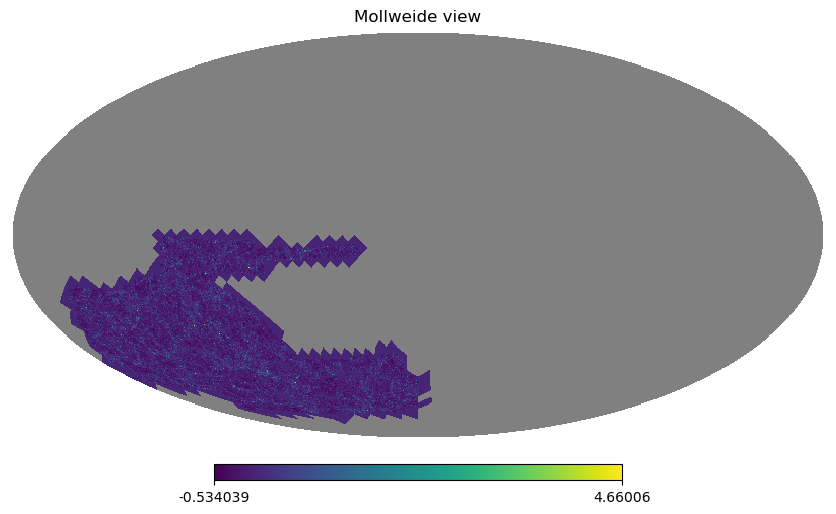

In [ ]:
hp_map = np.full(n_pix, hp.UNSEEN)
hp_map[data_vec_pix] = dg_dv[:,0]

hp.mollview(hp_map, nest=True)

# mean of a smooth map

In [ ]:
from msfm.utils import scales, files
data_vec_pix, _, _, _ = files.load_pixel_file()

23-08-17 15:30:49     files.py INF   Loaded the pixel file /Users/arne/git/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5 


In [ ]:
# number of galaxies per pixel
n_gal = 10

# print_statistics(dg, "delta_g")

for bg in [0.5, 1.0, 1.5, 2.0, 2.5]:
    print(f"bg = {bg}\n")

    # raw galaxy count, might contain pixel values that are below zero
    ng = n_gal * (1 + bg * dg)
    ng = np.clip(ng, a_min=0, a_max=None)

    # single redshift bin
    ng = ng[:,3]
    ng_dv = ng[data_vec_pix]

    ng_smooth = scales.data_vector_to_smoothed_data_vector(ng_dv, 1, 1500, 512, data_vec_pix)

    # print_statistics(ng_smooth, "ng smooth")
    print_statistics(ng_smooth_dv, "ng data vector smooth")

bg = 0.5

ng data vector smooth
min  = -12.0030
max  = 144.7986
mean = -0.1349

bg = 1.0

ng data vector smooth
min  = -12.0030
max  = 144.7986
mean = -0.1349

bg = 1.5

ng data vector smooth
min  = -12.0030
max  = 144.7986
mean = -0.1349

bg = 2.0

ng data vector smooth
min  = -12.0030
max  = 144.7986
mean = -0.1349

bg = 2.5

ng data vector smooth
min  = -12.0030
max  = 144.7986
mean = -0.1349



In [ ]:
# number of galaxies per pixel
n_gal = 10

# print_statistics(dg, "delta_g")

for bg in [0.5, 1.0, 1.5, 2.0, 2.5]:
    print(f"bg = {bg}\n")

    # raw galaxy count, might contain pixel values that are below zero
    ng = n_gal * (1 + bg * dg)
    ng = np.clip(ng, a_min=0, a_max=None)

    # single redshift bin
    ng = ng[:,0]
    # print_statistics(ng, "ng raw")

    ng_smooth = scales.map_to_smoothed_map(ng, 1, 1500, 512)
    ng_smooth_dv = ng_smooth[data_vec_pix]

    # print_statistics(ng_smooth, "ng smooth")
    print_statistics(ng_smooth_dv, "ng data vector smooth")

bg = 0.5

ng data vector smooth
min  = -2.7515
max  = 28.9656
mean = -0.0272

bg = 1.0

ng data vector smooth
min  = -5.5029
max  = 57.9312
mean = -0.0544

bg = 1.5

ng data vector smooth
min  = -8.2544
max  = 86.8968
mean = -0.0816

bg = 2.0

ng data vector smooth
min  = -10.7886
max  = 115.8624
mean = -0.1089

bg = 2.5

ng data vector smooth
min  = -12.0030
max  = 144.7986
mean = -0.1349

